                                               Bootstrap particle filter

This code implements the bootstrap particle filter as proposed in Gordon (1993) for stochastic volatility in Julia language.

In [1]:
versioninfo()

Julia Version 1.1.1
Commit 55e36cc308 (2019-05-16 04:10 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i7-4500U CPU @ 1.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)


Simulate data from a stochastic volatility model

In this respect, a hidden Markov process $\left \{ X_{t} \right \}_{t\geq 1}$ and a vector of observables $\left \{ Y_{t} \right \}_{t\geq 1}$ are generated from

\begin{align*}
X_{t}|X_{t-1} &=x_{t-1}\sim f_{\theta}(x_{t}|x_{t-1}), \qquad X_{1}=x_{1}\sim \mu_{\theta}(x_{1});\\
Y_{t}|X_{t}&=x_{t}\sim g_{\theta}(y_{t}|x_{t}).
\end{align*}

where $f_{\theta}(.|x_{t-1})$ is the probability distribution of the latent variable depending on a vector of structural parameters $\theta$, with initial condition distributed according to $\mu_{\theta}(x)=p\left (x_{1}| \theta \right )$. The probability function $g_{\theta}(.|x_{t})$ is the density distribution of the observables conditioned on the realization $x_{t}$ and the vector of structural parameters $\theta$.

In particular the stochastic volatility considered here takes the following form

\begin{align*}
X_{t}&=\alpha\, X_{t-1} + \sigma V_{t}\\
Y_{t}&=\beta\,exp\left \{ X_{t}/2 \right \}\zeta_{t}
\end{align*}

where the error terms are distributed
according to

\begin{equation}
\binom{V_{t}}{\zeta_{t}}\overset{iid}{\sim} N
\begin{pmatrix}\begin{matrix}
\begin{pmatrix}
0\\ 
0
\end{pmatrix}
\end{matrix},
\begin{pmatrix}
 \sigma^2 & 0\\ 
 0 & 1
\end{pmatrix}
\end{pmatrix}\nonumber.
\end{equation} 

Data are generated by setting the vector of structural parameters $\theta=\left ( \alpha, \sigma, \beta \right )$ to be $\theta_{\circ}=\left ( 0.9,\, 1\, , 0.7 \right )$ over a sample size $t = 1,2,...,T$, with $T=300$.

In [2]:
using Distributions    
using Optim
using Random                  
using Plots
using Calculus
using StatsFuns
using StatsBase 
using LinearAlgebra
using JLD

In [3]:
# Simulate stochastic volatility

θ = [.9, 1, 0.7];    # Define the vector of parameters
T = 300;             # Series length

function simSV(θ, T)
    Random.seed!(123);
    
    α, σ, β = θ
    println("Simulating SVM")
    println("α = ", α, ", σ = ", σ, ", β = ", β)    
    X = Array{Float64}(undef,T+1)
    Y = Array{Float64}(undef,T)
    X[1] = 0.0
    for t = 1:T
        X[t+1] = α*X[t] + σ*randn()
        Y[t]   = β*exp(X[t]/2)*randn()
    end
    return Y, X
end

Y, X = simSV(θ, T);

Simulating SVM
α = 0.9, σ = 1.0, β = 0.7


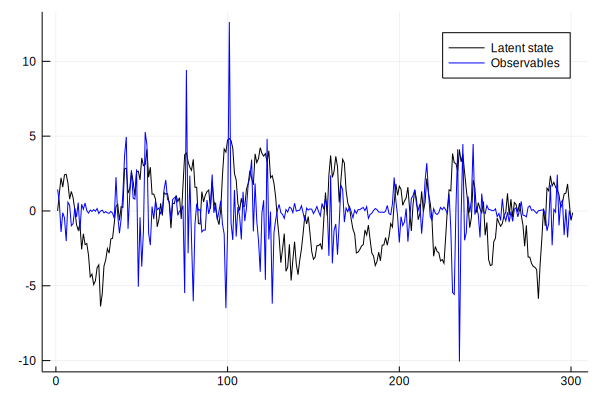

In [27]:
# Plot Observables vs Latent state

plot(X,line=(:black, 1, 1,:solid),label="Latent state")
plot!(Y,line=(:blue, 1, 1,:solid),label="Observables")

In [20]:
################################################################################################################################

When Bayesian inference is carried out with PMCMC methods, it relies on the joint probability distribution 


$$
p\left ( \theta, x_{1:T} |y_{1:T}\right )\propto p\left ( y_{1:T}|x_{1:T},\theta \right )\mu_{\theta}\left ( x_{1} \right )\prod_{t=2}^{T}p(x_{t}|y_{1:t-1},\,\theta)\,p(\theta)
$$


where $p\left ( y_{1:T}|x_{1:T},\theta \right )$ is the likelihood function, the density $p(x_{t}|y_{1:t-1},\,\theta)$ is the predictive distribution of the latent state for $t=2,...,T$ and the probability distribution $p(\theta)$ is a prior density for the vector of parameters $\theta$. 

When the likelihood function is intractable it needs to be approximated for the purpose of estimation. Particle filter is a particular case of the sequential Monte Carlo method. It delivers an unbiased estimate of the likelihood function which can be used inside MCMC algorithms to handle nonlinear/non-Gaussian estimation problem (see Flury and Shephard, 2011).

                                         Boostrap particle filter algorithm

Initialization. Set $t\leftarrow 1$.  For $i=1:N$:

[$(1)$] Sample $\tilde X^{i}_{1}\sim \mu_{\theta}\left ( x_{1} \right )$

[$(2)$] Compute the weights $W^{i}_{1} \propto\alpha^{i}_{1}\left (\tilde X^{i}_{1}\right )$, with $\alpha^{i}_{1}\left (\tilde X^{i}_{1}\right ) =g_{\theta}\left ( y_{1}|\tilde X^{i}_{1} \right )$

[$(3)$] Resample from $\left \{ W^{i}_{1}, \tilde X^{i}_{1} \right \}_{i=1}^{N}$ to obtain $\left \{ 1/N,  X^{i}_{1} \right \}_{i=1}^{N}$

Iteration At time $t \geq  2$, for $i=1:N$:

[$(1)$] Sample $\tilde X^{i}_{t}\sim f_{\theta}\left ( x_{t}| X^{i}_{t-1} \right )$

[$(2)$] Compute the weights $W^{i}_{t} \propto\alpha^{i}_{t}\left ( \tilde X^{i}_{t} \right  )W^{i}_{t-1}$, with $\alpha^{i}_{t}\left (\tilde X^{i}_{t} \right ) =g_{\theta}\left(y_{t}|\tilde X^{i}_{t}\right)$

[$(3)$] Set $\left \{\tilde X^{i}_{1:t} \right \}\leftarrow \left \{ X^{i}_{1:t-1},\tilde X^{i}_{t} \right \}$

[$(4)$] Resample from $\left \{ W^{i}_{t},\tilde X^{i}_{1:t} \right \}_{i=1}^{N}$ to obtain $\left \{ 1/N, X^{i}_{1:t} \right \}_{i=1}^{N}$

Define

$$\alpha_{t}\left ( \tilde x_{t} \right )=\frac{g_{\theta}\left ( y_{t}|\tilde x_{t} \right )f_{\theta}\left ( \tilde x_{t}|x_{t-1} \right )}{q\left ( \tilde x_{t}|y_{t}, \, x_{t-1}, \, \theta \right )}$$

and set the proposal distribution $q$ to be $q\left ( \tilde x_{t}|y_{t}, \, x_{t-1}, \, \theta \right ) = f_{\theta}\left ( \tilde x_{t}|x_{t-1} \right )$ in order to make particle filter feasible. Then, the incremental weights takes the following form

$$\alpha_{t}\left ( \tilde x_{t} \right )=g_{\theta}\left ( y_{t}|\tilde x_{t} \right )$$

Moreover, define

$$
W_{t}^i=\frac{\alpha_{t}^i\left ( \tilde X^{i}_{t} \right )W_{t-1}^i}{\frac{1}{N}\sum_{i=1}^{N} \alpha_{t}^{i}\left ( \tilde X^{i}_{t} \right )W_{t-1}^i}.
$$ 

In [10]:

N=1000  #Define the number of Particles to sample at each t

# Define function to be used inside particle filter  

# 1. Initial Condition latent state (stationarity is assumed)
function sampIC!(θ,l)
    α, σ, β = θ
    rand!(Normal(0, sqrt(σ^2/(1-α^2))), view(l,:,1))
end

# 2. Define incremental weights 
function normpdf!(θ,l,Y)
    α, σ, β = θ
    pdf(Normal(0, exp(l/2)), Y)
end

# 3. Simulate latent state
function sampREC!(θ,l)
    α, σ, β = θ
    rand(Normal(α*l, σ))
end

# 4. Resample step
function resample!(l, F, idx)
    N =  size(l, 1)
    sample!(1:N, Weights(F), idx)
    for i = eachindex(l)
        @inbounds l[i] = l[idx[i]]
        end    
    l
end

resample! (generic function with 1 method)

In [13]:
# Bootstrap particle filter

function SMC(θ,N,Y)
    #Definitions
          T = size(Y,1)
    α, σ, β = θ
          l = Array{Float64}(undef,N,T)    
          F = Array{Float64}(undef,N,T) 
        idx = Array{Int64}(undef,N)                                                                                                        
    
    #Latent State Initial Condition 
    sampIC!(θ,l)
    for i = 1:N
    F[i,1] = normpdf!(θ,l[i,1],Y[1])
       # F[i,1] = normpdfIC!(θ,l[i,1],Y[1])
    end
    #Log-likelihood initial condition
    llik = log(mean(F))
    #Resample Step Initial Condition
    resample!(view(l, :,1),F[:,1],idx)
    
    for t = 2:T 
        sFRec=0.0
        for i = 1:N 
            #Latent State   
            l[i,t] = sampREC!(θ,l[i,t-1])
            #Particle Weights  
            F[i,t] = normpdf!(θ,l[i,t],Y[t])
            sFRec += F[i,t]
        end
        #Log-likelihood
        @inbounds llik += log(sFRec)-log(N)
        #Resample Step
        resample!(view(l, :, t), F[:,t], idx)                               
    end
    return l,llik
end
nothing

In [21]:
# Run particle filter given the vector of true parameters 

@time l,llik = SMC(θ, N, Y); 

  0.067166 seconds (17.43 k allocations: 16.470 MiB, 27.26% gc time)


Particle filter delivers two outputs

$[(1)]$
$$
  ln\,\hat p(y_{1:T}|\theta)=  \sum_{t=1}^{T}\,ln\, \hat p(y_{t}|y_{1:t-1}, \theta).
$$

$[(2)]$
$$
\varphi_{t,N}=\frac{1}{N}\sum_{i=1}^{N}\varphi_{t}\left ( X_{1:t}^{i} \right )W_{t}^{i}.
$$

where [(1)] is the likelihood function with

$$
\hat p(y_{t}|y_{1:t-1}, \theta)=\frac{1}{N}\sum_{j=1}^{N} \alpha_{t}^i\left ( \tilde X^{i}_{t} \right )\,W_{t-1}^i 
$$

and the function $\varphi_{t,N}$ transforms particles into the object of interest. 

Display $ln\,\hat p(y_{1:T}|\theta_{\circ})$

In [23]:
#  [(1)]  log-likelihood function

llik

-428.55374701795455

Display mean and standard deviation of $\hat p(x_{t}|y_{1:t}, \theta_{\circ})$ for $t=1,2,...,300$

In [24]:
# [(1)] mean and standard deviation of the filtered latent state

X_est = Array{Float64}(undef,size(l,2))
V_est = Array{Float64}(undef,size(l,2))
SDmin = Array{Float64}(undef,size(l,2))
SDmax = Array{Float64}(undef,size(l,2))

for t = 1:size(l,2)
    X_est[t] = mean(l[:,t]);
    V_est[t] = var(l[:,t]);
end

 SDmin  = X_est[1:size(l,2)] - (V_est[1:size(l,2)]).^(1/2);
 SDmax = X_est[1:size(l,2)] + (V_est[1:size(l,2)]).^(1/2);

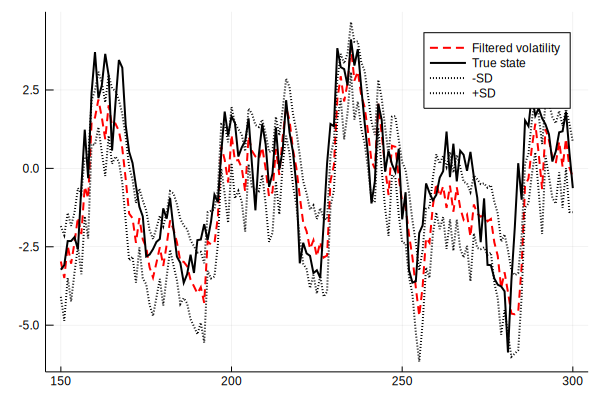

In [25]:
# Plot [(2)]

Start = 150
End   = size(X,1)-1

plot(Start:End,X_est[Start:End],line=(:red, 1, 2,:dash),label="Filtered volatility")
plot!(Start:End,X[Start:End],line=(:black, 1, 2,:solid),label="True state")
plot!(Start:End,SDmin[Start:End],line=(:black, 1, 2,:dot),label="-SD")
plot!(Start:End,SDmax[Start:End],line=(:black, 1, 2, :dot),label="+SD")  